Source: [U-Net: Training Image Segmentation Models in PyTorch](https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/)

In [1]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as Tr
from torch.optim.lr_scheduler import StepLR
from unet import Unet
from trainers import ClassifierTrainer

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class SegmentationDataset(Dataset):

    def __init__(self, path_images, path_masks, files, scale_x=255, scale_y=65535, transform=None):
        
        self.path_images = path_images
        self.path_masks = path_masks
        self.files = files
        self.scale_x = scale_x
        self.scale_y = scale_y
        self.transform = transform
    
    def __len__(self):
        
        return len(self.files)
    
    def __getitem__(self,index):
        
        img = Image.open(os.path.join(self.path_images, self.files[index]))
        img_mask = Image.open(os.path.join(self.path_masks, self.files[index]))

        if self.transform:
            sample = np.asanyarray(self.transform(img))
        else:
            sample = np.asanyarray(img)

        sample = sample[:,:,:3]
        sample = sample/self.scale_x

        label = np.asanyarray(img_mask)
        label = label/self.scale_y

        sample = torch.tensor(np.transpose(sample, (2,0,1)), dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        
        return sample, label

In [3]:
def plot_sample(dataset, index):
    
    (x, y) = dataset[index]
        
    img = (np.transpose(x.numpy(), (1,2,0)))
    img = Image.fromarray((255*img).astype(np.uint8))
    img_mask = y.numpy()
    img_mask = Image.fromarray((255*img_mask).astype(np.uint8))
    
    _, axs = plt.subplots(1,2, figsize=(3.5,3.5))
    axs[0].imshow(img, interpolation='nearest')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(img_mask, interpolation='nearest')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    return img, img_mask

# Setup the datasets

In [4]:
path_data = './data/Unet_data/train'
path_images = os.path.join(path_data, 'images')
path_masks = os.path.join(path_data, 'masks')

In [5]:
test_size = 0.15
seed_split = 42
batch_size = 50

In [6]:
files = os.listdir(path_images)
[train_files, test_files] = train_test_split(files, test_size=test_size, random_state=seed_split)

train_dataset = SegmentationDataset(path_images, path_masks, train_files, scale_x=255, scale_y=65535, transform=None)
test_dataset = SegmentationDataset(path_images, path_masks, test_files, scale_x=255, scale_y=65535, transform=None)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

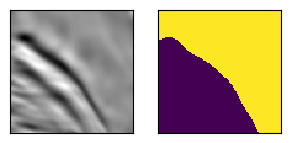

In [32]:
img, img_mask = plot_sample(train_dataset, index=174)

# make model

![Alt text](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/11/unet_small.png?lossy=1&strip=1&webp=1)

In [8]:
#Learning rate
learning_rate = 0.001
#Number of pochs
num_epochs = 30
#Initialize the model
model = Unet(cin=3, features=[32, 64, 128, 256], num_classes=2)
#Define the loss
weights = torch.tensor([0.2,0.8])
CUDA = torch.cuda.is_available()
if CUDA:
    weights = weights.cuda()
loss_fn = nn.CrossEntropyLoss(weight=weights)
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10**-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)

In [9]:
trainer = ClassifierTrainer(model, optimizer, train_loader, test_loader, False, scheduler, loss_fn)

In [10]:
%%time
trainer.fit(num_epochs)

Epoch 1/30, Training Loss: 0.480, Training Accuracy: 0.754, Testing Loss: 0.538, Testing Acc: 0.469
Epoch 2/30, Training Loss: 0.391, Training Accuracy: 0.805, Testing Loss: 0.418, Testing Acc: 0.786
Epoch 3/30, Training Loss: 0.367, Training Accuracy: 0.812, Testing Loss: 0.346, Testing Acc: 0.847
Epoch 4/30, Training Loss: 0.344, Training Accuracy: 0.831, Testing Loss: 0.506, Testing Acc: 0.833
Epoch 5/30, Training Loss: 0.339, Training Accuracy: 0.798, Testing Loss: 0.315, Testing Acc: 0.839
Epoch 6/30, Training Loss: 0.314, Training Accuracy: 0.806, Testing Loss: 0.335, Testing Acc: 0.775
Epoch 7/30, Training Loss: 0.314, Training Accuracy: 0.812, Testing Loss: 0.353, Testing Acc: 0.846
Epoch 8/30, Training Loss: 0.303, Training Accuracy: 0.816, Testing Loss: 0.417, Testing Acc: 0.840
Epoch 9/30, Training Loss: 0.297, Training Accuracy: 0.820, Testing Loss: 0.363, Testing Acc: 0.850
Epoch 10/30, Training Loss: 0.294, Training Accuracy: 0.819, Testing Loss: 0.345, Testing Acc: 0.801

In [11]:
model_file = './models/salt_unet_180323'
trainer.save_model(model_file)


# Model Evaluation

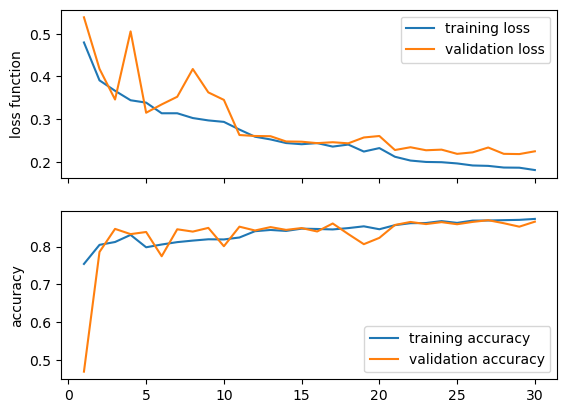

In [19]:
epochs = list(range(1,num_epochs+1))

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(epochs, trainer.train_losses)
axs[0].plot(epochs, trainer.test_losses)
axs[0].set_ylabel('loss function')
axs[0].legend(['training loss', 'validation loss'])
axs[1].plot(epochs, trainer.train_accuracies)
axs[1].plot(epochs, trainer.test_accuracies)
axs[1].set_ylabel('accuracy')
axs[1].legend(['training accuracy', 'validation accuracy'])

In [20]:
trainer.test_accuracies[-1]

0.8661870360374451

# Visualize predictions

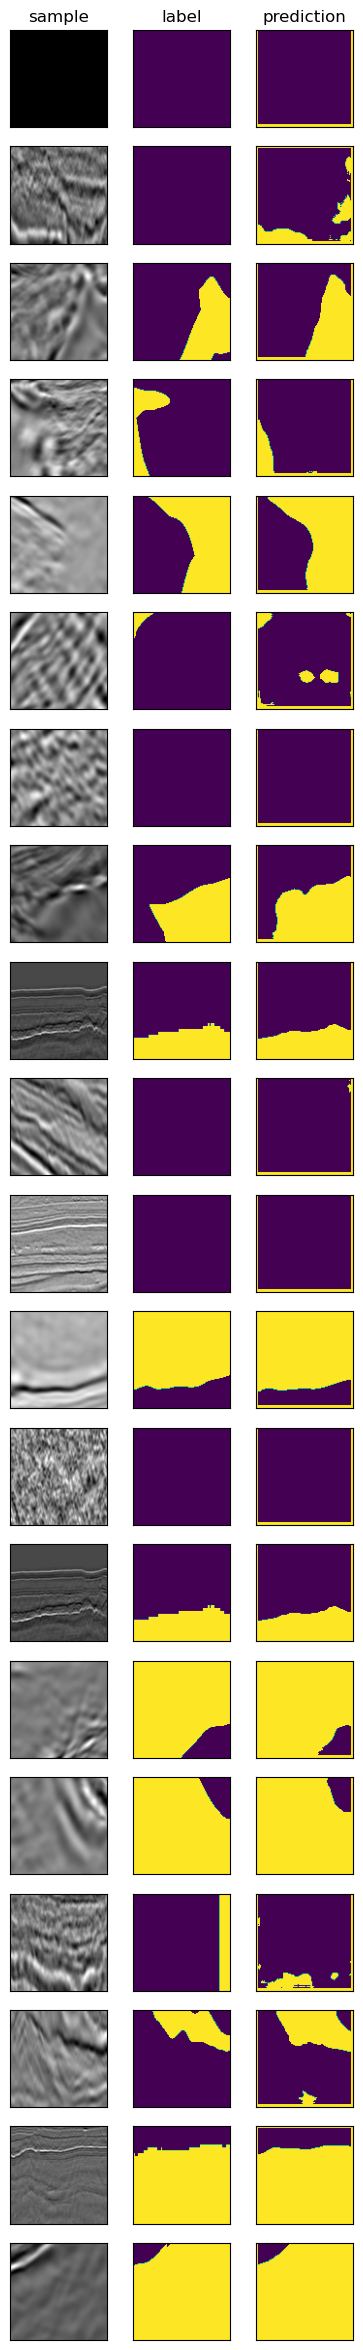

In [40]:
dataset = test_dataset

nrows = 20
ncols = 3
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(4.5,30))

for i in range(nrows):  
    idx = random.randint(0,len(dataset)-1)
    sample = dataset[idx][0].numpy().transpose(1,2,0)
    label = dataset[idx][1].numpy()
    prediction = trainer.predict(dataset, idx)
    prediction = prediction.numpy()[0,:,:]
    axs[i,0].imshow(sample)
    axs[i,2].imshow(prediction)
    axs[i,1].imshow(label)
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    axs[i,2].set_xticks([])
    axs[i,2].set_yticks([])
    if i==0:
        axs[i,0].set_title('sample')
        axs[i,1].set_title('label')
        axs[i,2].set_title('prediction')